# Installation

In [1]:
%load_ext autoreload

In [2]:
%pip uninstall -y tempo_embeddings
%pip install -e ..

Found existing installation: tempo_embeddings 0.0.1
Uninstalling tempo_embeddings-0.0.1:
  Successfully uninstalled tempo_embeddings-0.0.1
Note: you may need to restart the kernel to use updated packages.
Obtaining file:///Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for tempo_embeddings (pyproject.toml) ... done
  Created wheel for tempo_embeddings: filename=tempo_embeddings-0.0.1-0.editable-py3-none-any.whl size=9648 sha256=72f1ee523dad646959dac9f0c56fd2348cec4a507919253cf4957e42d4528a88
  Stored in directory: /private/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/pip-ephem-wheel-cache-wstfjh20/wheels/9d/dd/1c/d0e8ab6bde11a84556c00bd645333aaad0b90e2c38e11b0ed1
Successfully built tempo_embeddings
Note: you may need to r

In [3]:
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


# Initialize Database

In [8]:
from ipywidgets import widgets

host_selector = widgets.Dropdown(
    options=[("local", "localhost"), ("Research Cloud", "145.38.187.187")],
    value="145.38.187.187",
    description="DB Server:",
)
host_selector

Dropdown(description='DB Server:', index=2, options=(('local', 'localhost'), ('Research Cloud', '145.38.192.17…

In [5]:
%autoreload now

In [9]:
import weaviate
from tempo_embeddings.embeddings.model import SentenceTransformerModelWrapper
from tempo_embeddings.embeddings.weaviate_database import WeaviateDatabaseManager
from tempo_embeddings.settings import DEFAULT_LANGUAGE_MODEL

db = WeaviateDatabaseManager(
    client=weaviate.connect_to_local(host=host_selector.value, port=8087),
    model=SentenceTransformerModelWrapper.from_pretrained(DEFAULT_LANGUAGE_MODEL),
)

# Search

In [10]:
from ipywidgets import widgets

collection_selector = widgets.SelectMultiple(
    options=list(db.get_available_collections()),
    value=["Telegraaf", "Volkskrant", "NRC", "Trouw", "AlgemeenDagblad"],
    description="Choose a Collection:",
    disabled=False,
    style={"description_width": "initial"},
)
collection_selector

SelectMultiple(description='Choose a Collection:', index=(0, 2, 3, 4, 5), options=('Telegraaf', 'StatenGeneraa…

In [11]:
text_widget = widgets.Text(
    placeholder="Enter a term",
    description="Search Term:",
    disabled=False,
    value="duurzaam",
)
text_widget

Text(value='duurzaam', description='Search Term:', placeholder='Enter a term')

In [12]:
field = "genre"

## Retrieve genres from database:
# genres: set[str] = {
#     value
#     for collection in collection_selector.value
#     for value in db.get_metadata_values(collection, field)
# }

## Pre-defined genres (from newspaper sources):
genres: set[str] = {
    "familiebericht",
    "artikel",
    "illustratie met onderschrift",
    "advertentie",
}

exclude_genres = widgets.SelectMultiple(
    options=genres, value=["advertentie"], description=f"Exclude {field}(s):"
)
exclude_genres

SelectMultiple(description='Exclude genre(s):', index=(3,), options=('illustratie met onderschrift', 'familieb…

In [13]:
metadata_not = {field: list(exclude_genres.value)}

# Plot Frequencies

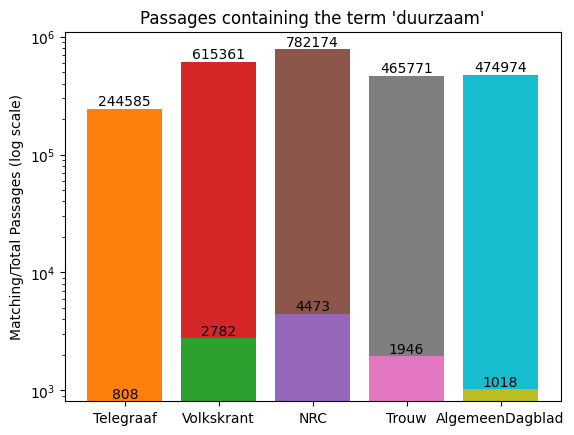

In [14]:
import matplotlib.pyplot as plt

assert text_widget.value.strip(), "No search term provided"

fig, ax = plt.subplots()

ax.set_title(f"Passages containing the term '{text_widget.value}'")

scale = "log"
ax.set_ylabel(f"Matching/Total Passages ({scale} scale)")
ax.set_yscale(scale)

for collection in collection_selector.value:
    doc_freq = db.doc_frequency(
        text_widget.value, collection, metadata_not=metadata_not
    )
    total_count = db.doc_frequency("", collection, metadata_not=metadata_not)

    bar_matches = ax.bar(collection, doc_freq, label=f"{collection} - Matches")
    ax.bar_label(bar_matches, fmt="%d", label_type="edge")

    bar_total = ax.bar(
        collection,
        total_count - doc_freq,
        bottom=doc_freq,
        label=f"{collection} - Total",
    )
    ax.bar_label(bar_total, fmt="%d", label_type="edge")

# Frequencies Per Year

In [15]:
start = 1850
end = 2024

year_range = widgets.SelectionRangeSlider(
    options=[str(i) for i in range(start, end)], index=(100, 150), description="Years"
)
year_range

SelectionRangeSlider(description='Years', index=(100, 150), options=('1850', '1851', '1852', '1853', '1854', '…

In [16]:
normalize = widgets.Checkbox(
    value=True, description="Normalize Frequencies", disabled=False
)
normalize

Checkbox(value=True, description='Normalize Frequencies')

In [17]:
import pandas as pd
from tqdm import tqdm

doc_freqs = pd.DataFrame(
    index=range(int(year_range.value[0]), int(year_range.value[1]))
)

for collection in tqdm(collection_selector.value, unit="collection"):
    doc_freqs[collection] = [
        db.doc_frequency(
            text_widget.value,
            collection,
            {"year": str(year)},
            metadata_not=metadata_not,
            normalize=normalize.value,
        )
        for year in doc_freqs.index
    ]

100%|██████████| 5/5 [00:11<00:00,  2.29s/collection]


<Axes: title={'center': "Normalized Frequency of 'duurzaam' (Rolling Average over 5 years)"}, xlabel='Year', ylabel='Normalized Frequency'>

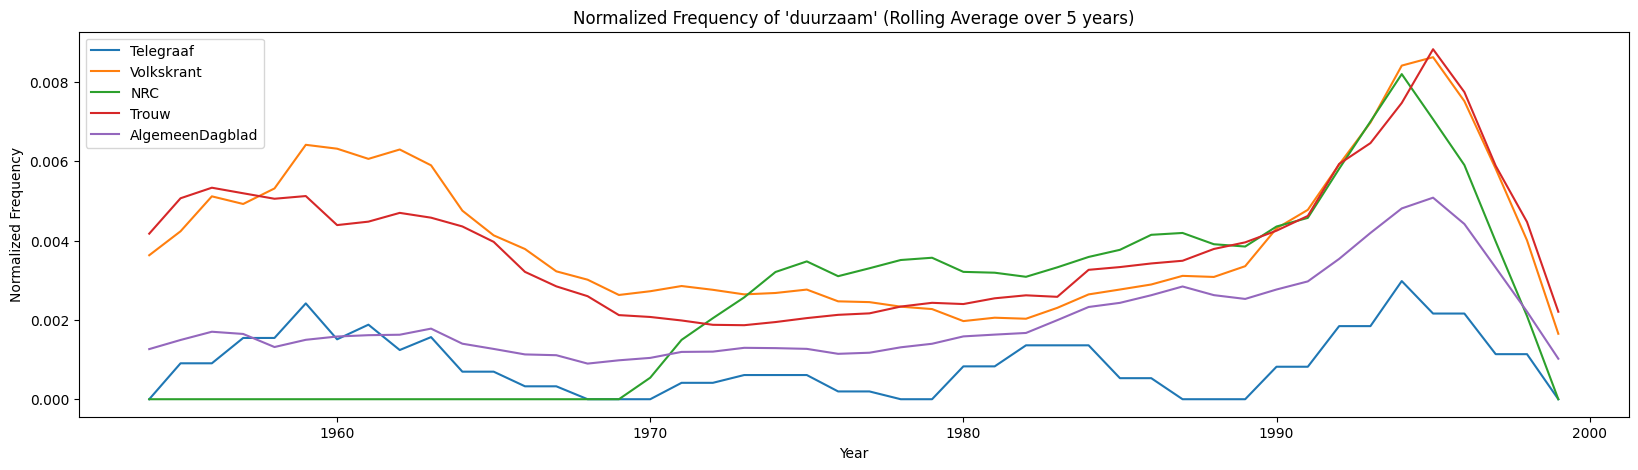

In [18]:
window_size = 5
_prefix = "Normalized " if normalize.value else ""

doc_freqs.rolling(window_size).mean().plot(
    figsize=(20, 5),
    title=f"{_prefix}Frequency of '{text_widget.value}' (Rolling Average over {window_size} years)",
    xlabel="Year",
    ylabel=f"{_prefix}Frequency",
)

# Create Corpus

In [19]:
%autoreload now

In [20]:
collections = [
    db.get_corpus(
        collection,
        [text_widget.value],
        year_from=year_range.value[0],
        year_to=year_range.value[1],
        include_embeddings=True,
        metadata_not=metadata_not,
    )
    for collection in collection_selector.value
]

## Expand Corpus with Close Passages

In [21]:
distance_widget = widgets.FloatSlider(
    value=0.4, min=0, max=1, step=0.01, description="Distance Threshold"
)

distance_widget

FloatSlider(value=0.4, description='Distance Threshold', max=1.0, step=0.01)

In [22]:
from tempo_embeddings.text.corpus import Corpus
from tempo_embeddings.text.passage import Passage
from tempo_embeddings.text.year_span import YearSpan

all_passages: set[Passage] = {
    passage for corpus in collections for passage in corpus.passages
}

neighbours: dict[Corpus, Corpus] = {
    collection: db.neighbours(
        collection,
        k=len(collection),  # at most, double the collection
        collections=collection_selector.value,
        distance=distance_widget.value,
        year_span=YearSpan(year_range.value[0], year_range.value[1]),
        metadata_not=metadata_not,
        exclude_passages=all_passages,
    )
    for collection in tqdm(collections, unit="collection", desc="Getting Neighbours")
}

Getting Neighbours: 100%|██████████| 5/5 [00:09<00:00,  1.95s/collection]


In [23]:
label_length: int = max(len(collection.label) for collection in collections)

print(
    f"{'Collection Label'.ljust(label_length)}\tSize\tNeighbours with Distance < {distance_widget.value}"
)
for collection in collections:
    print(
        f"{collection.label.ljust(label_length)}\t{len(collection)}\t{len(neighbours[collection])}"
    )

Collection Label           	Size	Neighbours with Distance < 0.4
Telegraaf: 'duurzaam'      	461	32
Volkskrant: 'duurzaam'     	2189	158
NRC: 'duurzaam'            	1894	159
Trouw: 'duurzaam'          	1859	172
AlgemeenDagblad: 'duurzaam'	1018	47


# Merge Collections

In [24]:
%autoreload now

In [25]:
from tempo_embeddings.text.corpus import Corpus

corpus = sum(collections + list(neighbours.values()), Corpus())
corpus.label = "Newspapers plus Neighbours"

In [26]:
corpus.compress_embeddings()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


array([[11.11776161,  1.5893333 ],
       [11.15521812,  1.18800902],
       [10.1033287 ,  3.30200887],
       ...,
       [ 6.66405773,  3.54738331],
       [13.45766258,  2.33983874],
       [11.86308956,  6.23149443]])

## Plot Corpus

In [27]:
from tempo_embeddings.settings import STOPWORDS
from tempo_embeddings.text.keyword_extractor import KeywordExtractor

keyword_extractor = KeywordExtractor(
    corpus, exclude_words=STOPWORDS | {text_widget.value}
).fit()

/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [28]:
%autoreload now

from tempo_embeddings.text.keyword_extractor import KeywordExtractor
from tempo_embeddings.visualization.jscatter import JScatterVisualizer

visualizer = JScatterVisualizer(
    corpus,
    categorical_fields=["newspaper", "label"],
    continuous_filter_fields=["year"],
    keyword_extractor=keyword_extractor,
)
visualizer.visualize()

Button(description='Return', style=ButtonStyle(), tooltip='Return to initial view')

Text(0.5, 1.0, "Cluster Sizes for 'duurzaam'")

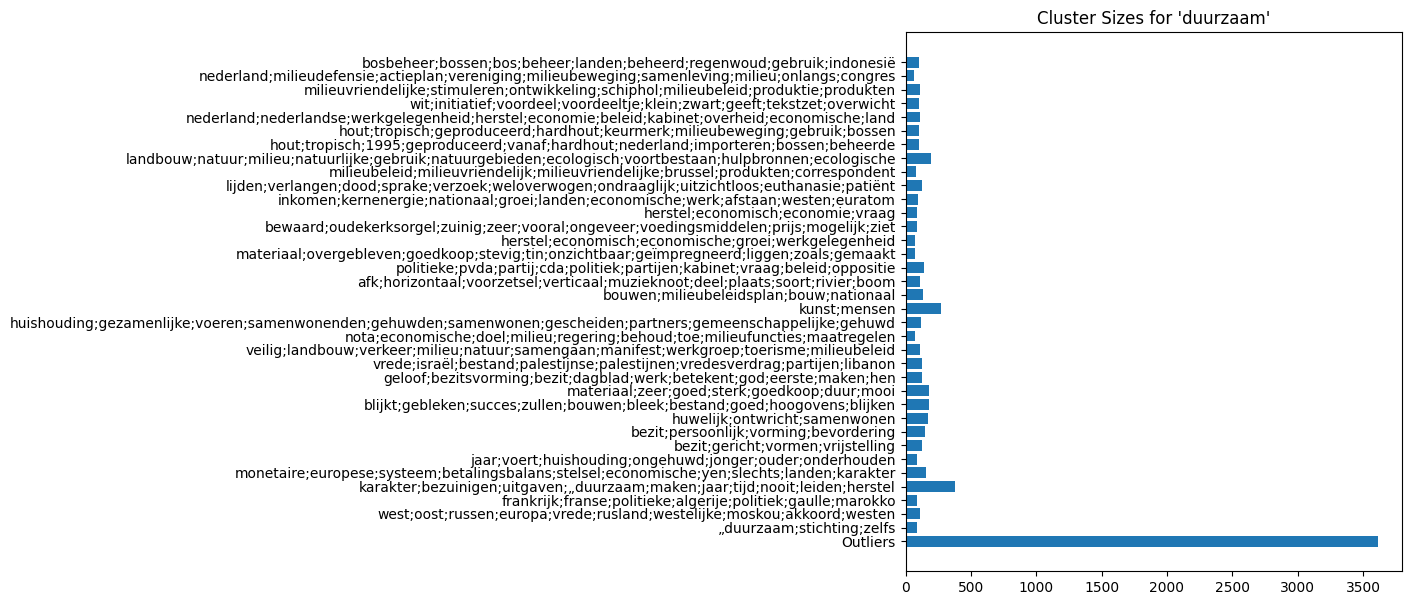

In [33]:
clusters = visualizer.clusters

fig, ax = plt.subplots()
fig.set_figheight(len(clusters) // 5)


ax.barh([c.top_words_string() for c in clusters], [len(c) for c in clusters])
ax.set_title(f"Cluster Sizes for '{text_widget.value}'")

# Cluster-based Statistics

In [34]:
import random

cluster_selector = widgets.Dropdown(
    options=[(cluster.top_words_string(), i) for i, cluster in enumerate(clusters)],
    value=random.randint(0, len(clusters) - 1),
    description="Choose a Cluster:",
)
cluster_selector

Dropdown(description='Choose a Cluster:', index=28, options=(('Outliers', 0), ('„duurzaam;stichting;zelfs', 1)…

In [35]:
cluster: Corpus = clusters[cluster_selector.value]

<Axes: title={'center': "Relative frequency of cluster 'landbouw;natuur;milieu;natuurlijke;gebruik;natuurgebieden;ecologisch;voortbestaan;hulpbronnen;ecologische' by newspaper"}, xlabel='newspaper', ylabel='Sentence Count'>

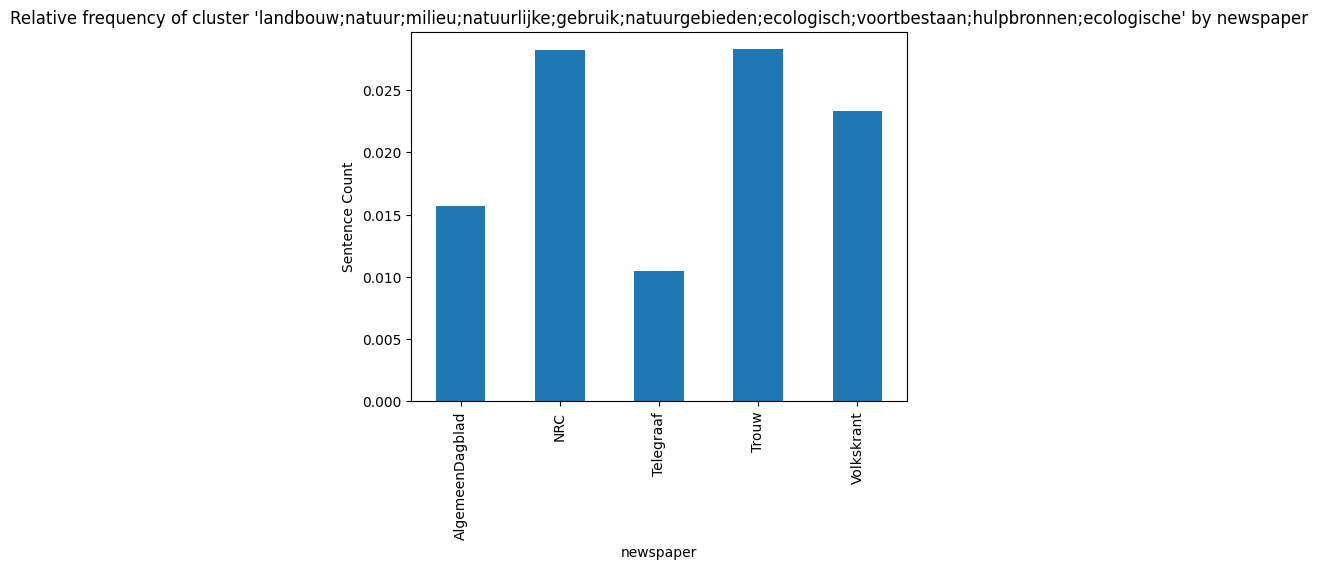

In [36]:
field = "newspaper"


corpus_per_newspaper = pd.Series(
    corpus.get_metadatas(field, default_value="NRC")
).value_counts()

cluster_per_newspaper = pd.Series(
    cluster.get_metadatas(field, default_value="NRC")
).value_counts()

(cluster_per_newspaper / corpus_per_newspaper).sort_index().plot(
    kind="bar",
    title=f"Relative frequency of cluster '{cluster.top_words_string()}' by {field}",
    xlabel=field,
    ylabel="Sentence Count",
)

In [37]:
field = "year"

corpus_per_year = pd.Series(
    corpus.get_metadatas(field, default_value=None)
).value_counts()

<Axes: title={'center': "Cluster 'landbouw;natuur;milieu;natuurlijke;gebruik;natuurgebieden;ecologisch;voortbestaan;hulpbronnen;ecologische' (Rolling average over 5 years)"}, xlabel='year', ylabel='Sentence Count'>

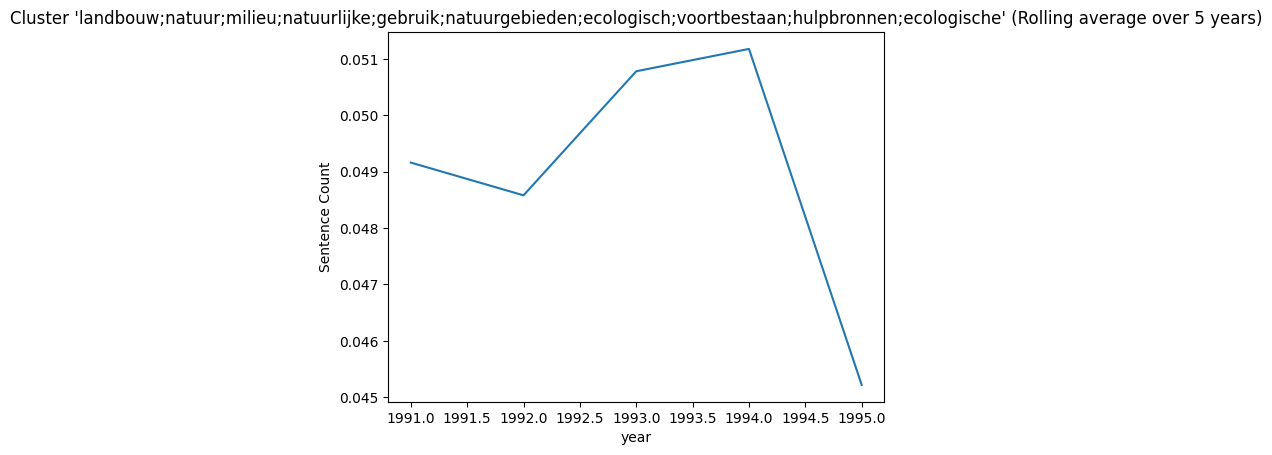

In [38]:
cluster_per_year = pd.Series(
    cluster.get_metadatas(field, default_value=None)
).value_counts()

(cluster_per_year / corpus_per_year).sort_index().rolling(window_size).mean().plot(
    title=f"Cluster '{cluster.top_words_string()}' (Rolling average over {window_size} years)",
    xlabel=field,
    ylabel="Sentence Count",
)

In [39]:
clusters_per_year = []
for c in clusters:
    if not c.is_outliers():
        s = (
            pd.Series(c.get_metadatas(field, default_value=None)).value_counts()
            / corpus_per_year
        )
        s.name = c.top_words_string()
        clusters_per_year.append(s)

clusters_per_year = pd.concat(clusters_per_year, axis=1)

<Axes: title={'center': 'Yearly Distribution of Clusters'}>

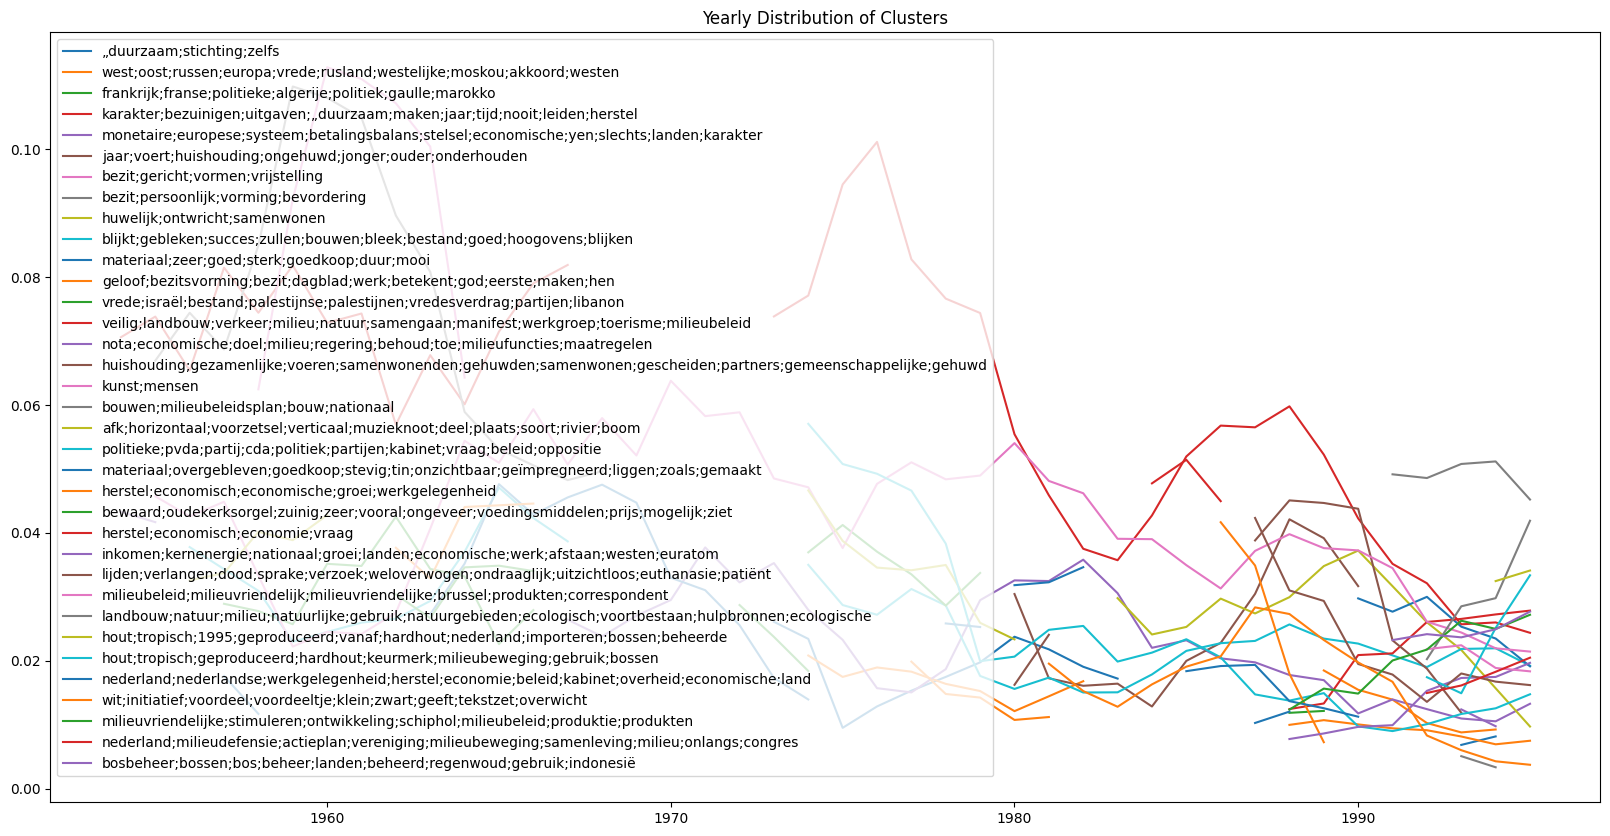

In [40]:
clusters_per_year.sort_index().rolling(window_size).mean().plot(
    kind="line", figsize=(20, 10), title="Yearly Distribution of Clusters"
)

## Cluster Analysis per Years

In [41]:
windows = sorted(
    cluster.windows(5, start=int(year_range.value[0]), stop=int(year_range.value[1])),
    key=lambda c: c.label,
)

In [42]:
print(f"Windows for cluster '{cluster}':")
for window in windows:
    window.top_words = keyword_extractor.top_words(window)

    print(window)

Windows for cluster 'Corpus('Newspapers plus Neighbours; cluster 13', 192 passages, top words=['landbouw', 'natuur', 'milieu', 'natuurlijke', 'gebruik', 'natuurgebieden', 'ecologisch', 'voortbestaan', 'hulpbronnen', 'ecologische'])':
Corpus('Newspapers plus Neighbours; cluster 13 1955-1960', 1 passages, top words=['weefsels', 'gewassen', 'gemakkelijker', 'vanzelfsprekend', 'duurzamer', 'ontstaan'])
Corpus('Newspapers plus Neighbours; cluster 13 1970-1975', 1 passages, top words=['zelfsprekend', 'organismen', 'onderhevig', 'biologisch', 'bederf', 'voeding', 'beton'])
Corpus('Newspapers plus Neighbours; cluster 13 1975-1980', 9 passages, top words=['éducation', 'meldt', 'milieuproblemen', 'permanente', 'ontwikkelingen', 'activiteiten', 'richting', 'maatschappelijke', 'mogelijkheden', 'arbeidsverdeling'])
Corpus('Newspapers plus Neighbours; cluster 13 1980-1985', 6 passages, top words=['afgedekt', 'vervuilde', 'isolatie', 'dik', 'plastic', 'grond'])
Corpus('Newspapers plus Neighbours; clu

In [43]:
cluster_extractor = KeywordExtractor(
    cluster, exclude_words=STOPWORDS | {text_widget.value}
).fit()

/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [44]:
print(
    f"Frequent words per window relative to this cluster ({cluster.top_words_string()}):"
)
print("-" * 80)

for window in windows:
    print(window)
    print(cluster_extractor.top_words(window))

Frequent words per window relative to this cluster (landbouw;natuur;milieu;natuurlijke;gebruik;natuurgebieden;ecologisch;voortbestaan;hulpbronnen;ecologische):
--------------------------------------------------------------------------------
Corpus('Newspapers plus Neighbours; cluster 13 1955-1960', 1 passages, top words=['weefsels', 'gewassen', 'gemakkelijker', 'vanzelfsprekend', 'duurzamer', 'ontstaan'])
['gemakkelijker', 'duurzamer', 'vanzelfsprekend', 'ontstaan', 'weefsels']
Corpus('Newspapers plus Neighbours; cluster 13 1970-1975', 1 passages, top words=['zelfsprekend', 'organismen', 'onderhevig', 'biologisch', 'bederf', 'voeding', 'beton'])
['metalen', 'steen', 'glas', 'velen', 'voeding', 'organismen', 'beton', 'onderhevig', 'bederf', 'lijken']
Corpus('Newspapers plus Neighbours; cluster 13 1975-1980', 9 passages, top words=['éducation', 'meldt', 'milieuproblemen', 'permanente', 'ontwikkelingen', 'activiteiten', 'richting', 'maatschappelijke', 'mogelijkheden', 'arbeidsverdeling'])